1. 폰트설정 및 csv파일 읽어들이기

In [2]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get -qq -y install fonts-nanum > /dev/null
#fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

#font = fm.FontProperties(fname=fontpath, size=9)

#fm._rebuild()



fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설

2. 데이터셋 읽어들이고 1~6학년 대출기록으로 필터링 후 가장 많이 대출된 1만개의 도서를 추출


In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df1 = pd.read_csv('/content/202307.csv')
# 학년이 1~6인 데이터만 필터링
df_filtered = df1[(df1['학년'] >= 1) & (df1['학년'] <= 6)]

# 도서명 상위 10,000권 추출
top_books = df_filtered['도서명'].value_counts().head(10000)

# 결과 출력
print(top_books)


도서명
고양이 해결사 깜냥. 5: 편의점을 환하게 밝혀라!                  1863
(읽으면서 바로 써먹는)어린이 속담                           1863
고양이 해결사 깜냥. 4: 눈썰매장을 씽씽 달려라!                  1465
(읽으면서 바로 써먹는)어린이 수수께끼                         1457
고양이 해결사 깜냥. 3: 태권도의 고수가 되어라!                  1386
                                              ... 
흔한 남매의 흔한 호기심. 6: 식물은 어떻게 계절을 알고 꽃을 피울까? 외      12
랑랑별 때때롱                                         12
(설민석의)삼국지. 2                                    12
빨리 놀자 삼총사                                       12
동생을 데리고 미술관에 갔어요                                12
Name: count, Length: 10000, dtype: int64


3. 가장 많이 대출된 책 1만개를 알라딘 api와 비교하여 장르를 도출


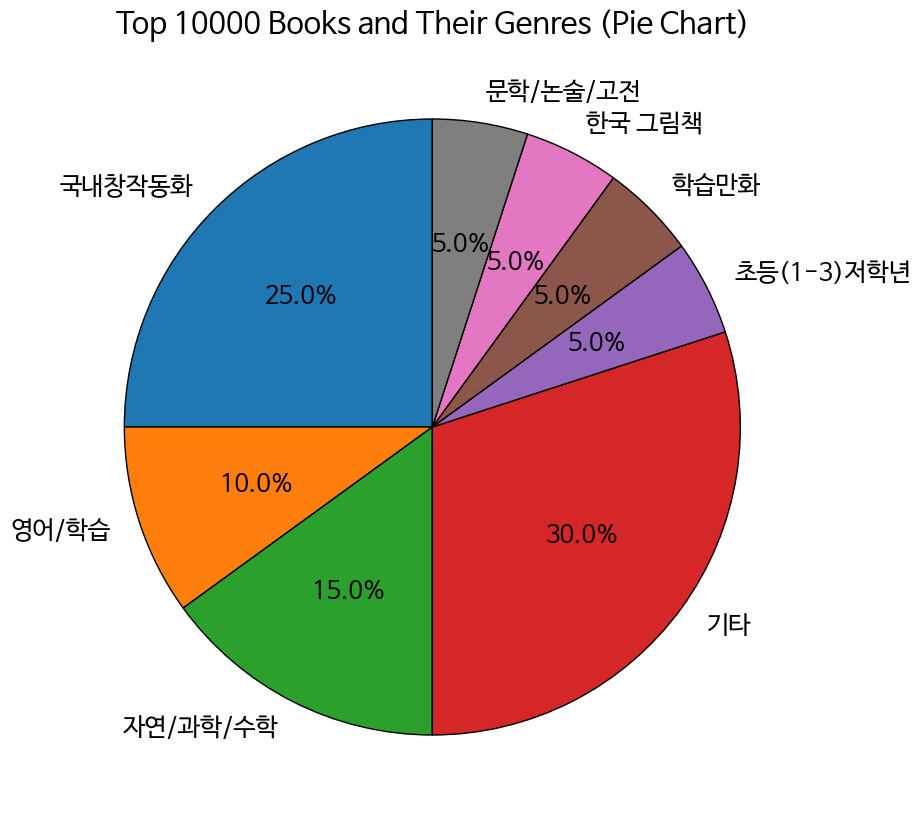

In [26]:
import requests
from xml.etree import ElementTree
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 장르 가져오기 함수
def search_book_genre_by_title(book_title, api_key):
    url = f'http://www.aladin.co.kr/ttb/api/ItemSearch.aspx'
    params = {
        'ttbkey': api_key,  # Aladin API 키
        'QueryType': 'keyword',  # 도서 제목으로 검색
        'Query': book_title,  # 책 제목
        'SearchTarget': 'Book',  # 도서 검색
        'MaxResults': '1',  # 검색된 책 1개만
        'Output': 'XML'  # XML 응답
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        try:
            # XML 파싱
            namespace = {'ns': 'http://www.aladin.co.kr/ttb/apiguide.aspx'}
            tree = ElementTree.fromstring(response.text)

            # categoryName 추출
            category = tree.find('.//ns:item/ns:categoryName', namespace)
            if category is not None:
                return category.text
            else:
                return None
        except ElementTree.ParseError as e:
            print(f"XML Parsing Error for {book_title}: {e}")
            return None
    else:
        print(f"Error fetching data for {book_title}, HTTP Status: {response.status_code}")
        return None

# CSV 파일에서 도서명 데이터를 읽어오기
csv_file_path = '/content/202307.csv'  # CSV 파일 경로
df = pd.read_csv(csv_file_path)

# 도서명 상위 nn개 추출
top_books = df['도서명'].value_counts().head(20).index.tolist()

# 알라딘 API 키 설정
api_key = 'ttbskagns012341931001'

# 각 책 제목에 대해 장르 정보 받아오기
book_genres = {}
for title in top_books:
    genre = search_book_genre_by_title(title, api_key)
    if genre:
        # '>'로 분리 후 마지막 텍스트만 추출
        short_genre = genre.split('>')[-1]
        book_genres[title] = short_genre
    else:
        book_genres[title] = "기타"




# 결과 출력
#print("Book Genres:")
#for book, genre in book_genres.items():
 #   print(f"{book}: {genre}")

# 장르 통계 계산
genre_counts = Counter(book_genres.values())
# 장르별 책의 수를 계산
labels = list(genre_counts.keys())  # 장르 이름
sizes = list(genre_counts.values())  # 도서 개수

# 원형 그래프 생성
plt.figure(figsize=(10, 10))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',  # 비율 표시
    startangle=90,  # 시작 각도
    wedgeprops={'edgecolor': 'black'}  # 경계선 추가
)

plt.title('Top 10000 Books and Their Genres (Pie Chart)')
plt.show()

4. 학년별 대출횟수 비교


        학교명   학년          도서명        대출일자
0  서울신현초등학교  1.0     야구장 가는 날  2023-07-01
1  서울신현초등학교  1.0     틀리면 어떡해?  2023-07-01
2    명지초등학교  1.0     구두장이꼬마요정  2023-07-01
3    명지초등학교  1.0      호두까기 인형  2023-07-01
4    명지초등학교  1.0  브레멘의 동물 음악대  2023-07-01
1~6학년별 도서 대출량:
학년
1    180756
2    151480
3    136447
4    109834
5     93923
6     51209
Name: count, dtype: int64


<ipython-input-27-a4b75c2754da>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['학년'] = df_filtered['학년'].astype(int)


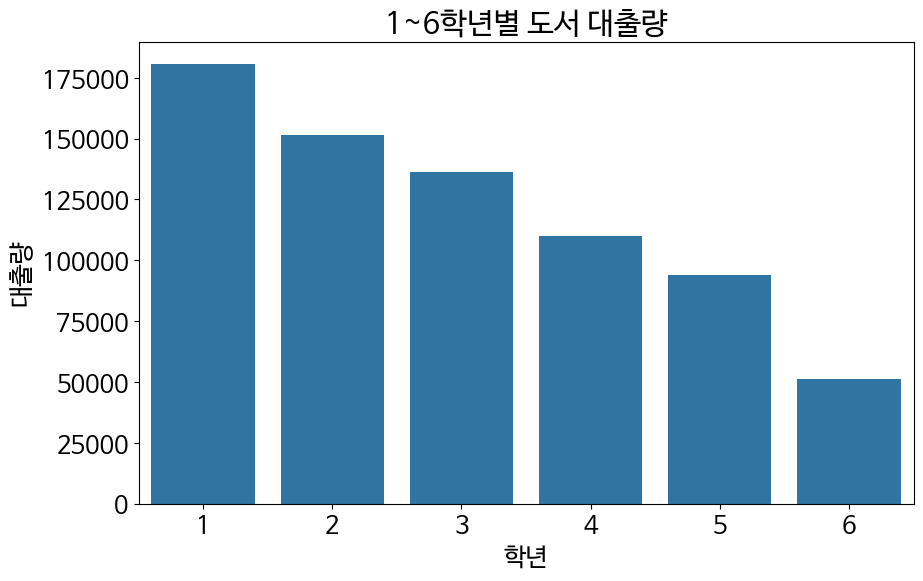

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 읽기
csv_file_path = '/content/202307.csv'  # CSV 파일 경로
df = pd.read_csv(csv_file_path)

# 데이터프레임 구조 확인
print(df.head())  # 데이터셋에 학년 정보가 포함되어 있는지 확인

# 학년별 대출량 집계
if '학년' in df.columns:
    df_filtered = df[(df['학년'] >= 1) & (df['학년'] <= 6)]  # 1~6학년 데이터만 필터링

    df_filtered['학년'] = df_filtered['학년'].astype(int)
    # 학년별 대출량 집계
    grade_counts = df_filtered['학년'].value_counts().sort_index()  # 학년별 대출량 계산 및 정렬

    # 결과 출력
    print("1~6학년별 도서 대출량:")
    print(grade_counts)

    # 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=grade_counts.index, y=grade_counts.values)
    plt.xlabel('학년')
    plt.ylabel('대출량')
    plt.title('1~6학년별 도서 대출량')
    plt.show()
else:
    print("데이터셋에 '학년' 컬럼이 없습니다.")

5. 학년별 가장 많이 대출된 책의 장르 비교

   학년                           도서명      장르  대출 횟수
0   1           (읽으면서 바로 써먹는)어린이 속담   영어/학습    605
1   2           (읽으면서 바로 써먹는)어린이 속담   영어/학습    569
2   3  고양이 해결사 깜냥. 5: 편의점을 환하게 밝혀라!  국내창작동화    472
3   4  고양이 해결사 깜냥. 5: 편의점을 환하게 밝혀라!  국내창작동화    398
4   5  고양이 해결사 깜냥. 5: 편의점을 환하게 밝혀라!  국내창작동화    215
5   6                           아몬드      문학    141


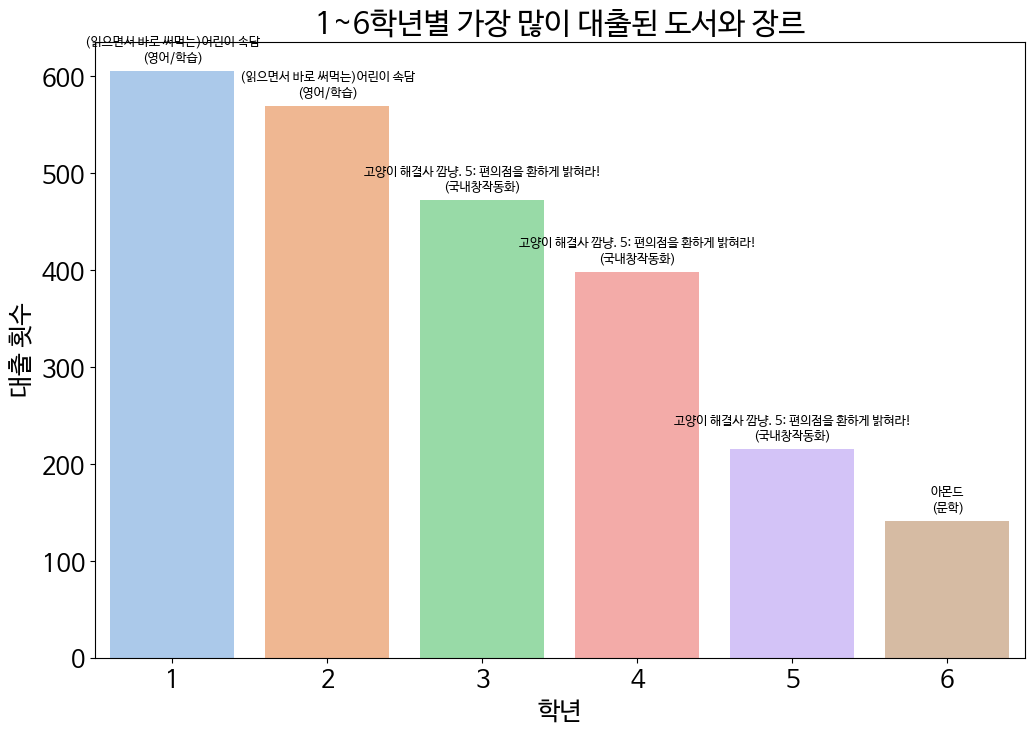

In [38]:


# 학년별로 가장 많이 대출된 도서 추출
top_books_by_grade = df_filtered.groupby('학년')['도서명'].value_counts().groupby('학년').idxmax()
top_books_counts = df_filtered.groupby('학년')['도서명'].value_counts().groupby('학년').max()

# 도서명에서 학년 부분 제거
cleaned_books_by_grade = {int(grade): title if isinstance(title, str) else title[1] for grade, title in top_books_by_grade.items()}

# 학년별 도서 장르 가져오기
book_genres_by_grade = []
for grade, title in cleaned_books_by_grade.items():
    # 6학년의 경우 api호출의 한계로 인해 다른책이 선택되어버려 본래 '아몬드'의 장르인 "문학"으로 설정
    if grade == 6:
        short_genre = "문학"
    else:
        genre = search_book_genre_by_title(title, api_key)
        short_genre = genre.split('>')[-1] if genre else "기타"

    book_genres_by_grade.append({'학년': grade, '도서명': title, '장르': short_genre, '대출 횟수': top_books_counts[grade]})

# 데이터프레임으로 변환
grade_genres_df = pd.DataFrame(book_genres_by_grade)

# 학년 값을 정수형으로 변환 (이미 처리되었지만 다시 확인)
grade_genres_df['학년'] = grade_genres_df['학년'].astype(int)

# 결과 출력
print(grade_genres_df)

# 막대그래프 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=grade_genres_df, x='학년', y='대출 횟수', dodge=False, palette='pastel')

# 그래프에 텍스트 추가 (도서명과 장르)
for i, row in grade_genres_df.iterrows():
    plt.text(
        i,
        row['대출 횟수'] + 10,
        f"{row['도서명']}\n({row['장르']})",
        ha='center',
        fontsize=9,
        color='black'
    )

plt.xlabel('학년')
plt.ylabel('대출 횟수')
plt.title('1~6학년별 가장 많이 대출된 도서와 장르')
plt.xticks(rotation=0)
plt.show()